In [2]:
from utils import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Exploration of the data

## Checks
First, we want to check if the nodes are not duplicated for each transport.

In [3]:
df_network_combined = pd.read_csv('data/adelaide/network_combined.csv', sep=';')
df_network_combined.head()

,from_stop_I,to_stop_I,d,duration_avg,n_vehicles,route_I_counts,route_type
0,1,2,616,60.000000,36,474:36,2
1,2,3,1456,203.333333,36,474:36,2
2,3,8,9522,540.000000,3,474:3,2
3,3,4,1506,176.666667,36,"473:4,474:32",2
4,3,5,2557,240.000000,21,473:21,2


In [4]:
df_network_nodes = pd.read_csv('data/adelaide/network_nodes_labeled.csv')
df_network_nodes.head()

,stop_I,lat,lon,name,city_center
0,1,-34.594537,138.747886,Gawler Central Railway Station,0
1,2,-34.595140,138.741200,Gawler Oval Railway Station,0
2,3,-34.608171,138.739819,Gawler Railway Station,0
3,4,-34.620412,138.732799,Evanston Railway Station,0
4,5,-34.628232,138.726211,Tambelin Railway Station,0


In [5]:
df_network_nodes['stop_I'].is_unique

True

In [6]:
# Gather all the data about the nodes
df_nodes = gather_all_data('data')
df_nodes.head()

,stop_I,lat,lon,name,city_center,city
0,1,-34.594537,138.747886,Gawler Central Railway Station,0,adelaide
1,2,-34.595140,138.741200,Gawler Oval Railway Station,0,adelaide
2,3,-34.608171,138.739819,Gawler Railway Station,0,adelaide
3,4,-34.620412,138.732799,Evanston Railway Station,0,adelaide
4,5,-34.628232,138.726211,Tambelin Railway Station,0,adelaide


## Size of each city and the distribution of labels

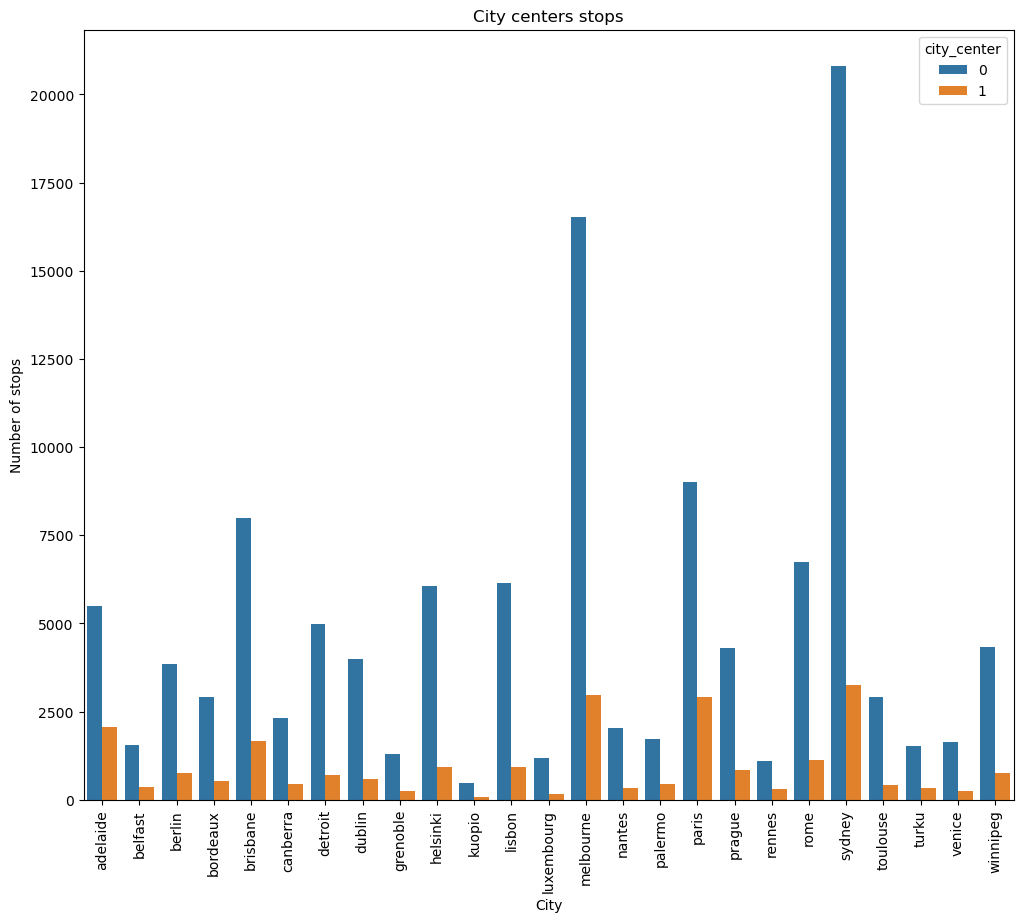

In [7]:
sns.countplot(df_nodes, x='city', hue='city_center')
plt.title('City centers stops')
plt.ylabel('Number of stops')
plt.xlabel('City')
plt.xticks(rotation=90)
plt.show()

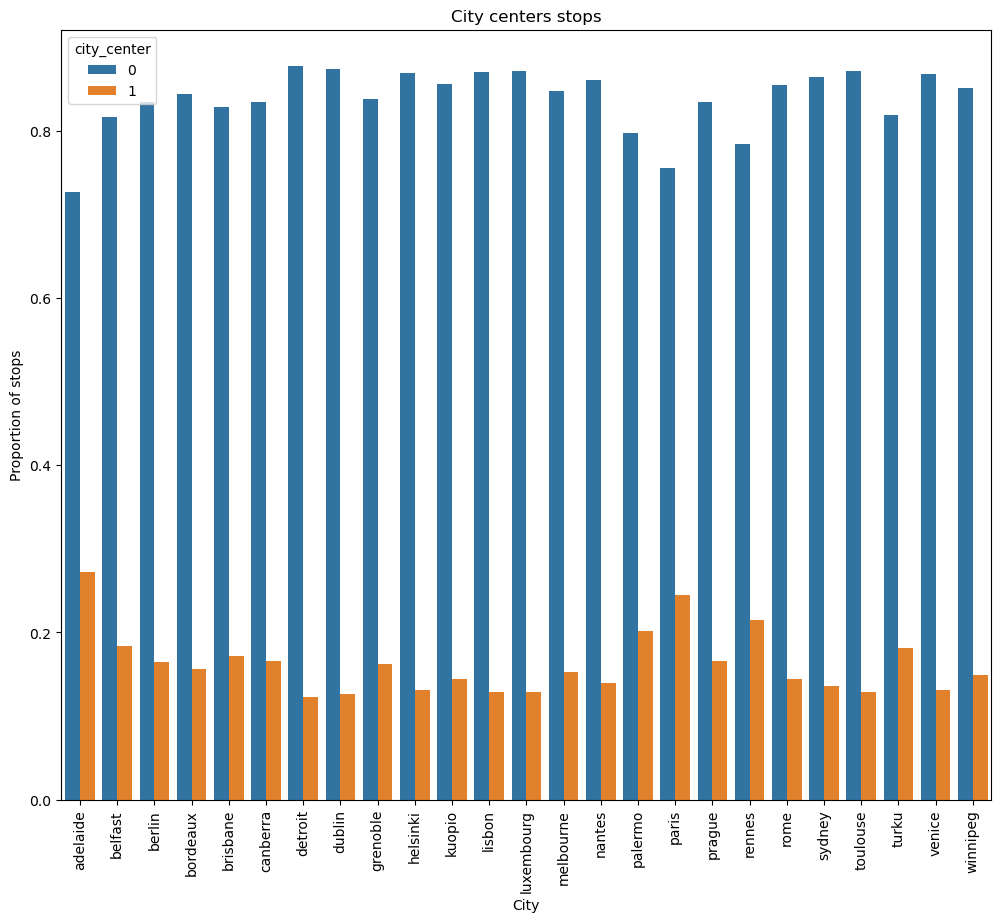

In [8]:
df_nodes_normalized = df_nodes.groupby('city')[['city', 'city_center']].value_counts(normalize=True).rename('proba').reset_index()
df_nodes_normalized.head()

sns.barplot(df_nodes_normalized, x='city', y='proba', hue='city_center')
plt.title('City centers stops')
plt.ylabel('Proportion of stops')
plt.xlabel('City')
plt.xticks(rotation=90)
plt.show()

## Types of transports

Here we are interested in the types of transport each city has, their distribution and how they behave compared to the city centers labels.

In [9]:
df_nodes['stop_I'].is_unique

False

In [10]:
df_nodes['stop_city'] = df_nodes.apply(lambda x: f'{x["stop_I"]}_{x["city"]}', axis=1)
df_nodes.set_index('stop_city', inplace=True)

In [11]:
df_links = gather_all_data('data', nodes=False)
df_links.head()

,from_stop_I,to_stop_I,d,duration_avg,n_vehicles,route_I_counts,route_type,city
0,1,2,616,60.000000,36,474:36,2,adelaide
1,2,3,1456,203.333333,36,474:36,2,adelaide
2,3,8,9522,540.000000,3,474:3,2,adelaide
3,3,4,1506,176.666667,36,"473:4,474:32",2,adelaide
4,3,5,2557,240.000000,21,473:21,2,adelaide


In [12]:
df_links['from_stop_city'] = df_links.apply(lambda x: f'{x["from_stop_I"]}_{x["city"]}', axis=1)
df_links['to_stop_city'] = df_links.apply(lambda x: f'{x["to_stop_I"]}_{x["city"]}', axis=1)

In [13]:
df_l = df_links.join(df_nodes['city_center'], on='from_stop_city', how='left').rename(columns={'city_center': 'city_center_from'})
df_l = df_l.join(df_nodes['city_center'], on='to_stop_city', how='left').rename(columns={'city_center': 'city_center_to'})

In [14]:
(df_l['city_center_from'] != df_l['city_center_to']).mean()

0.01750476001804955

In [15]:
df_l = df_l[df_l['city_center_from'] == df_l['city_center_to']]

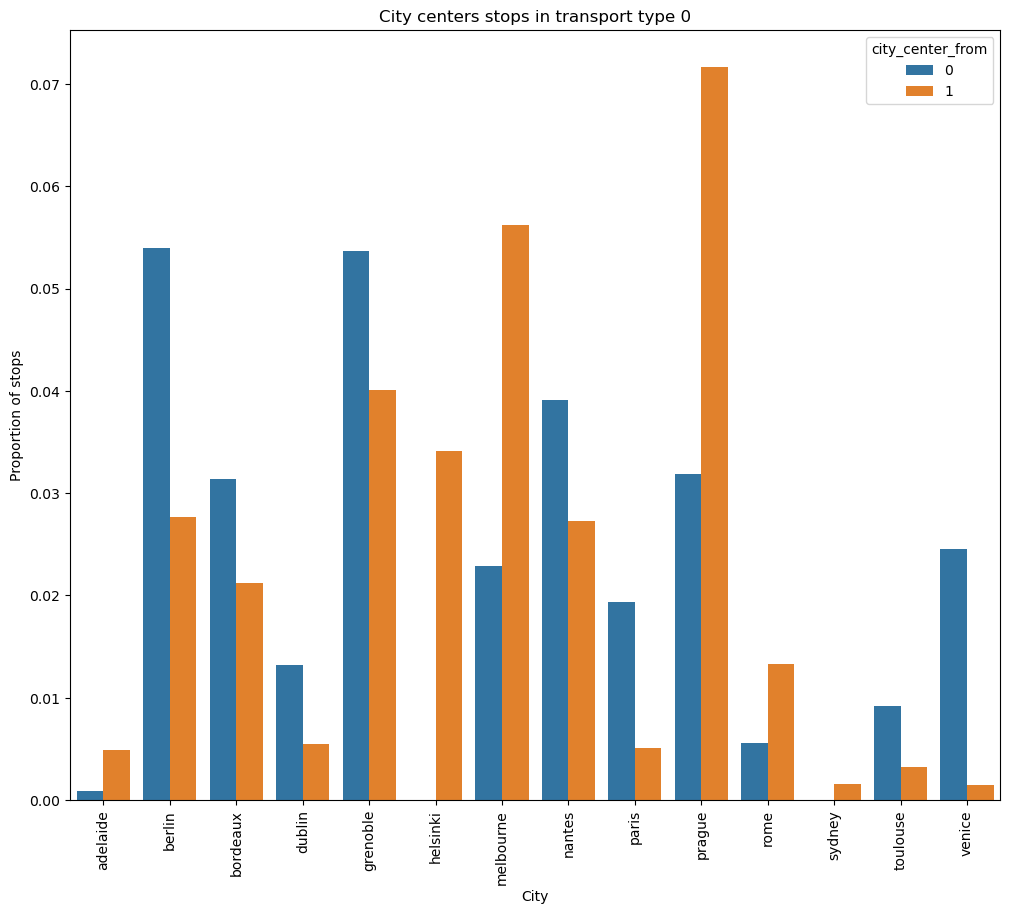

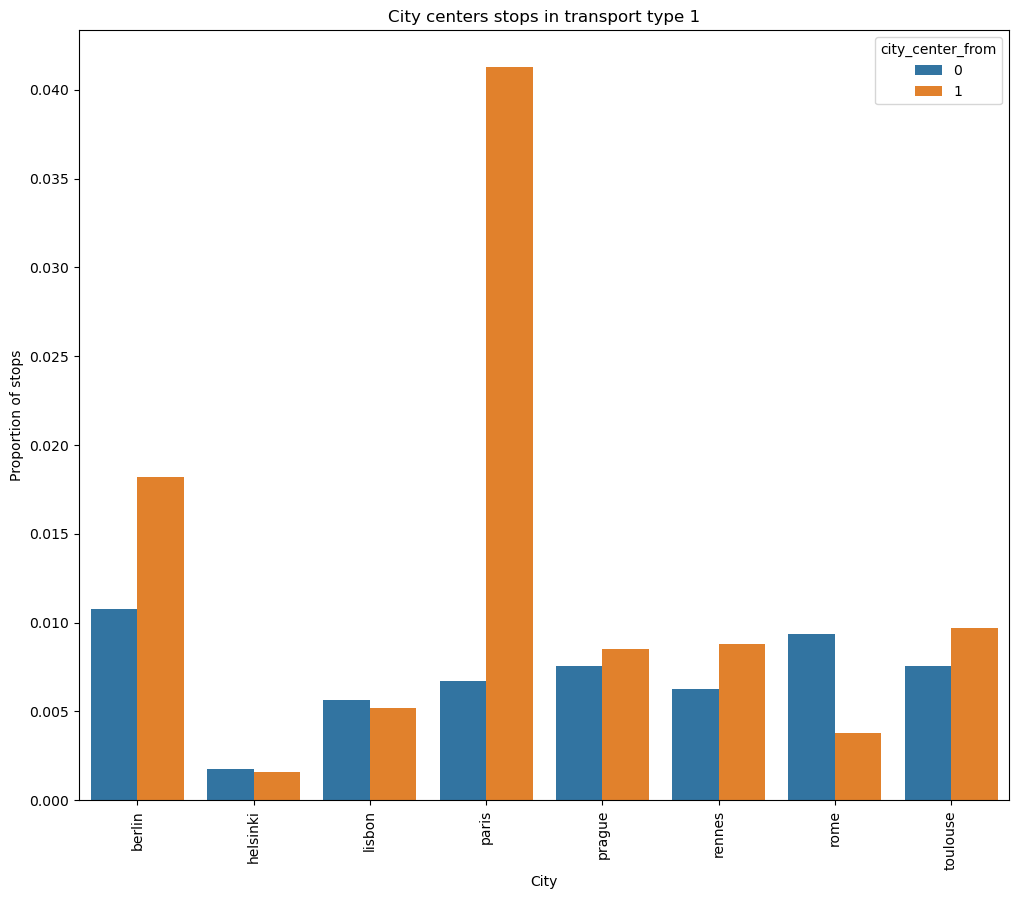

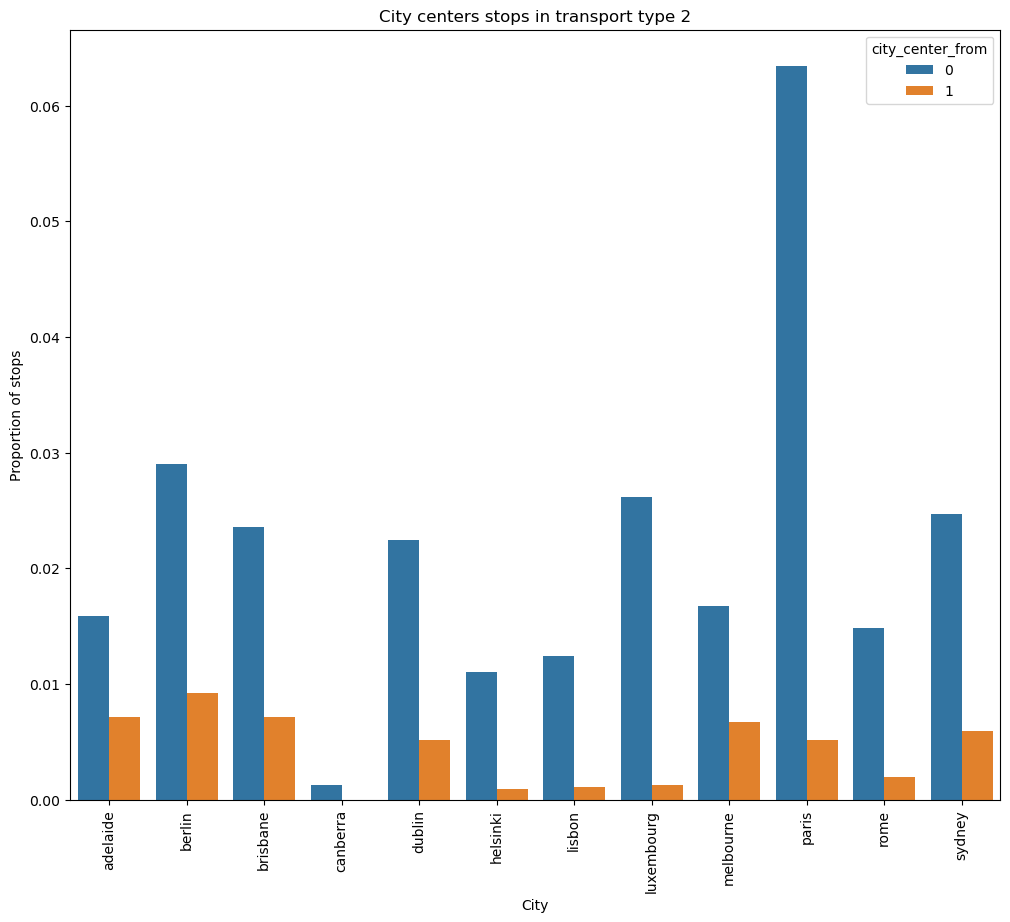

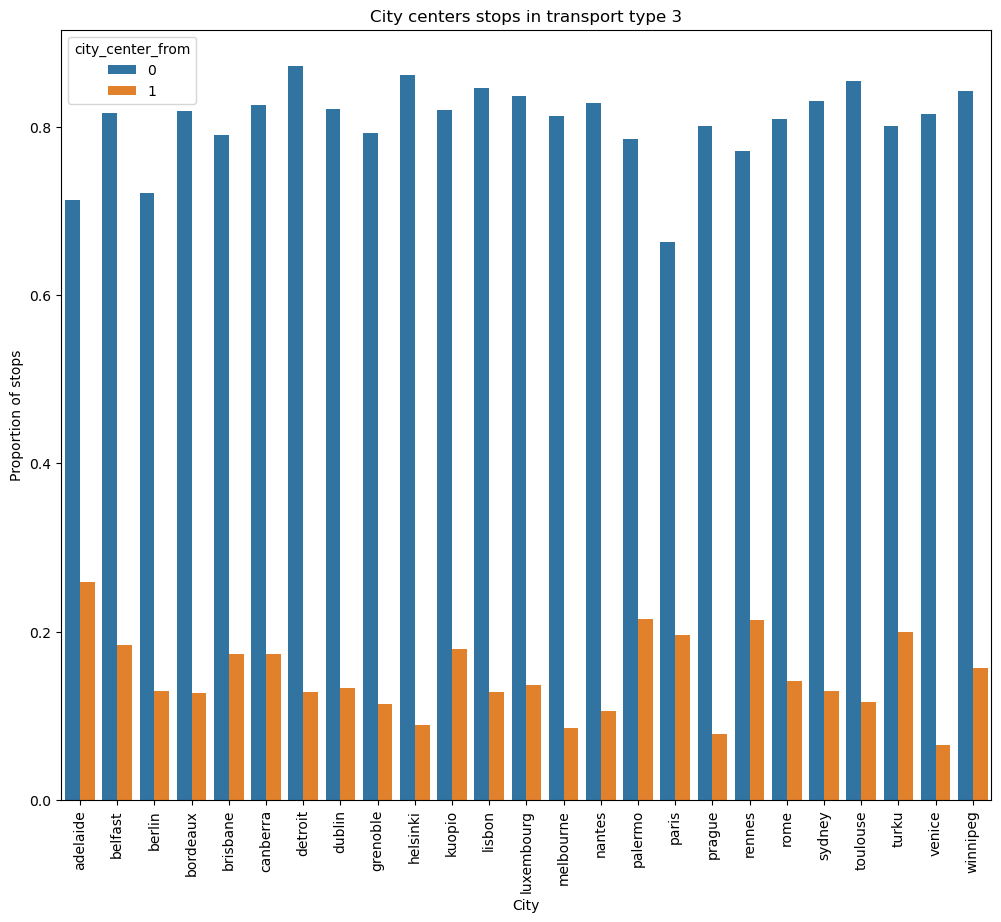

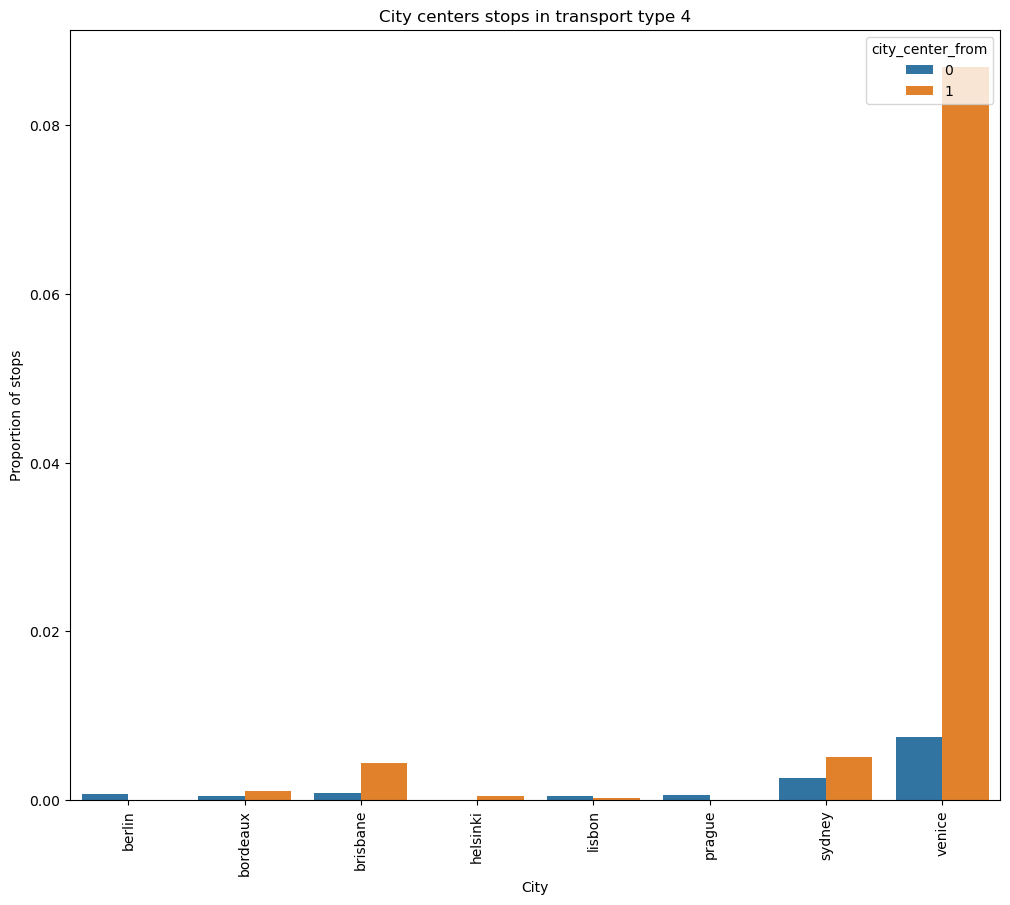

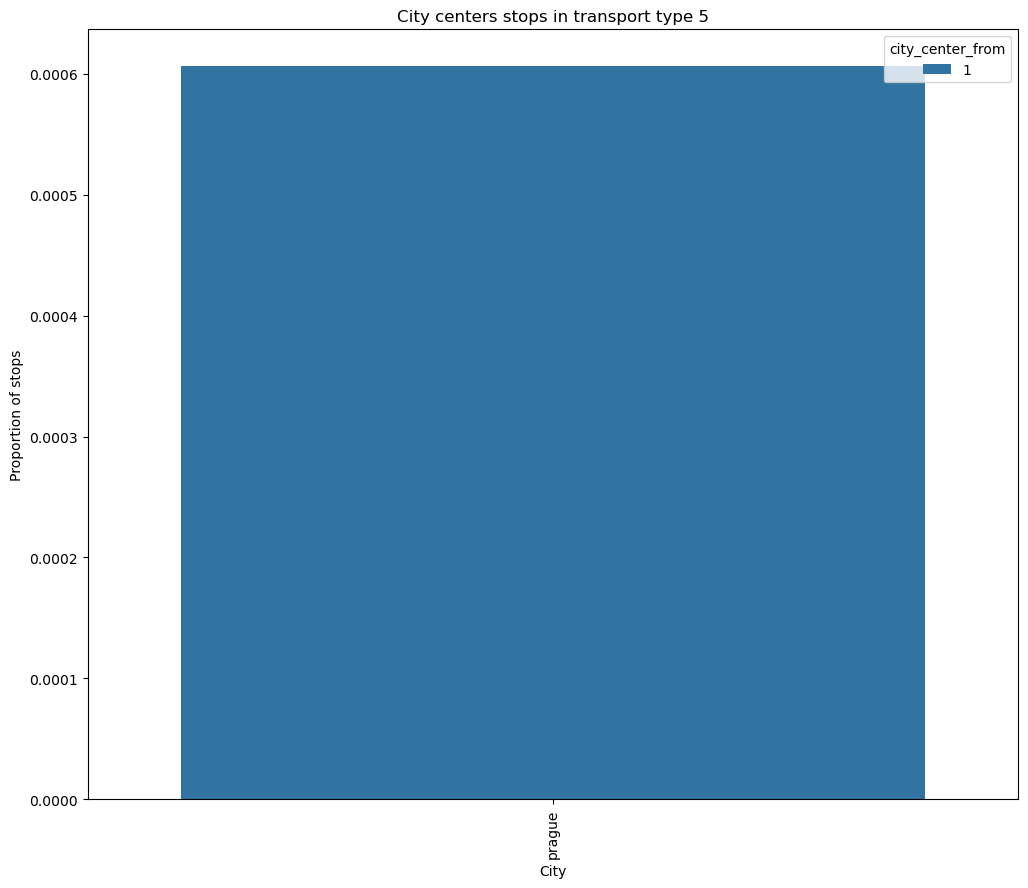

In [16]:
df_l_normalized = df_l.groupby('city')[['route_type', 'city_center_from']].value_counts(normalize=True).rename('proba').reset_index()

transport_types = sorted(df_l_normalized['route_type'].unique().tolist())

for t in transport_types:
    sns.barplot(df_l_normalized[df_l_normalized['route_type'] == t], x='city', y='proba', hue='city_center_from')
    plt.title(f'City centers stops in transport type {t}')
    plt.ylabel('Proportion of stops')
    plt.xlabel('City')
    plt.xticks(rotation=90)
    plt.show()

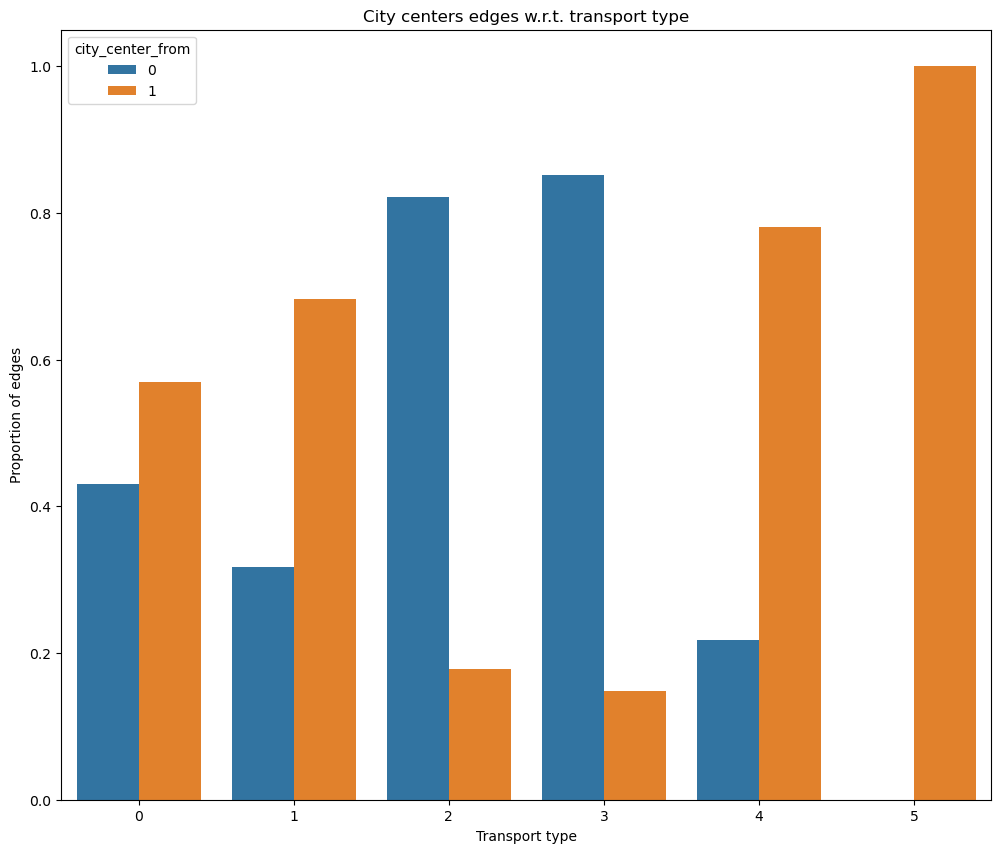

In [17]:
df_l_normalized = df_l.groupby('route_type')[['city_center_from']].value_counts(normalize=True).rename('proba').reset_index()

sns.barplot(df_l_normalized, x='route_type', y='proba', hue='city_center_from')
plt.title(f'City centers edges w.r.t. transport type')
plt.ylabel('Proportion of edges')
plt.xlabel('Transport type')
plt.show()

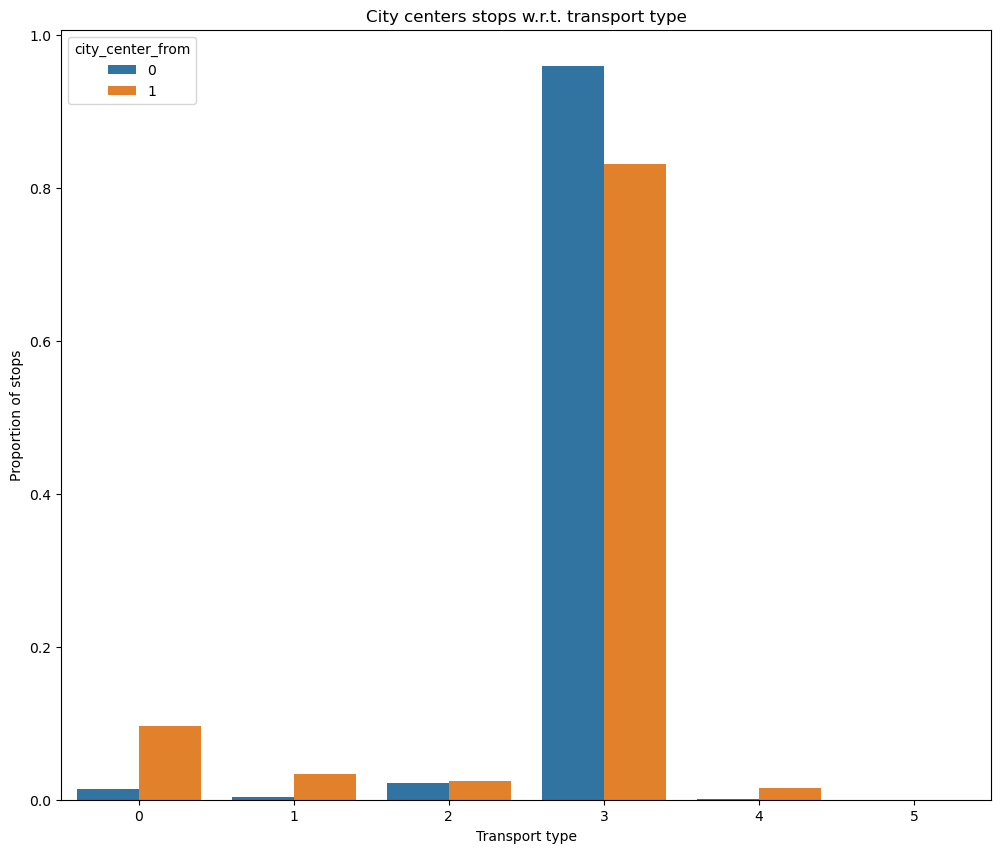

In [18]:
df_l_normalized = df_l.groupby('city_center_from')[['route_type']].value_counts(normalize=True).rename('proba').reset_index()

#sns.barplot(df_l_normalized, x='city_center_from', y='proba', hue='route_type')
sns.barplot(df_l_normalized, x='route_type', y='proba', hue='city_center_from')
plt.title(f'City centers stops w.r.t. transport type')
plt.ylabel('Proportion of stops')
plt.xlabel('Transport type')
plt.show()

## Average duration of transport

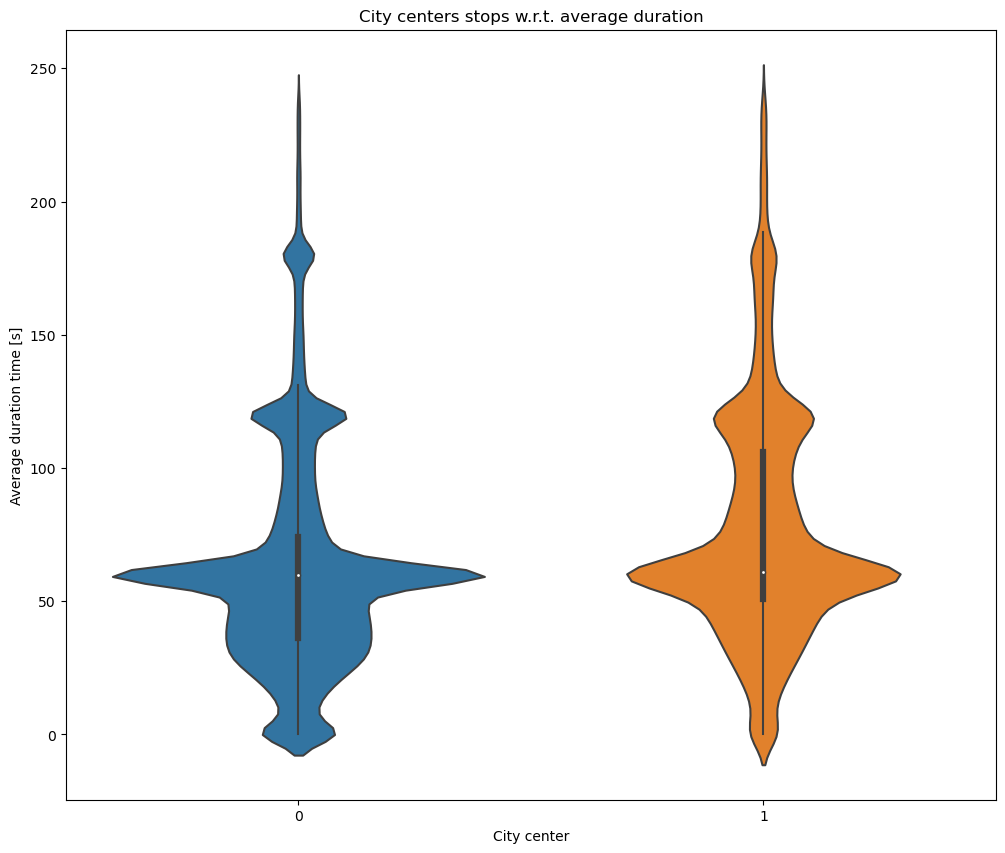

In [39]:
df_l_outliers = df_l[df_l['duration_avg'] < df_l['duration_avg'].quantile(0.97)]
sns.violinplot(df_l_outliers, x='city_center_from', y='duration_avg')
plt.title(f'City centers stops w.r.t. average duration')
plt.ylabel('Average duration time [s]')
plt.xlabel('City center')
plt.show()

In [40]:
df_l.groupby('city_center_from').max()

,from_stop_I,to_stop_I,d,duration_avg,n_vehicles,route_I_counts,route_type,city,from_stop_city,to_stop_city,city_center_to
city_center_from,,,,,,,,,,,
0,41465,41465,47965,6600.0,1093,"9:9,1173:6",4,winnipeg,9_winnipeg,9_winnipeg,0
1,41793,41793,7459,3780.0,1623,"9:9,10:3,11:100",5,winnipeg,9_venice,9_venice,1


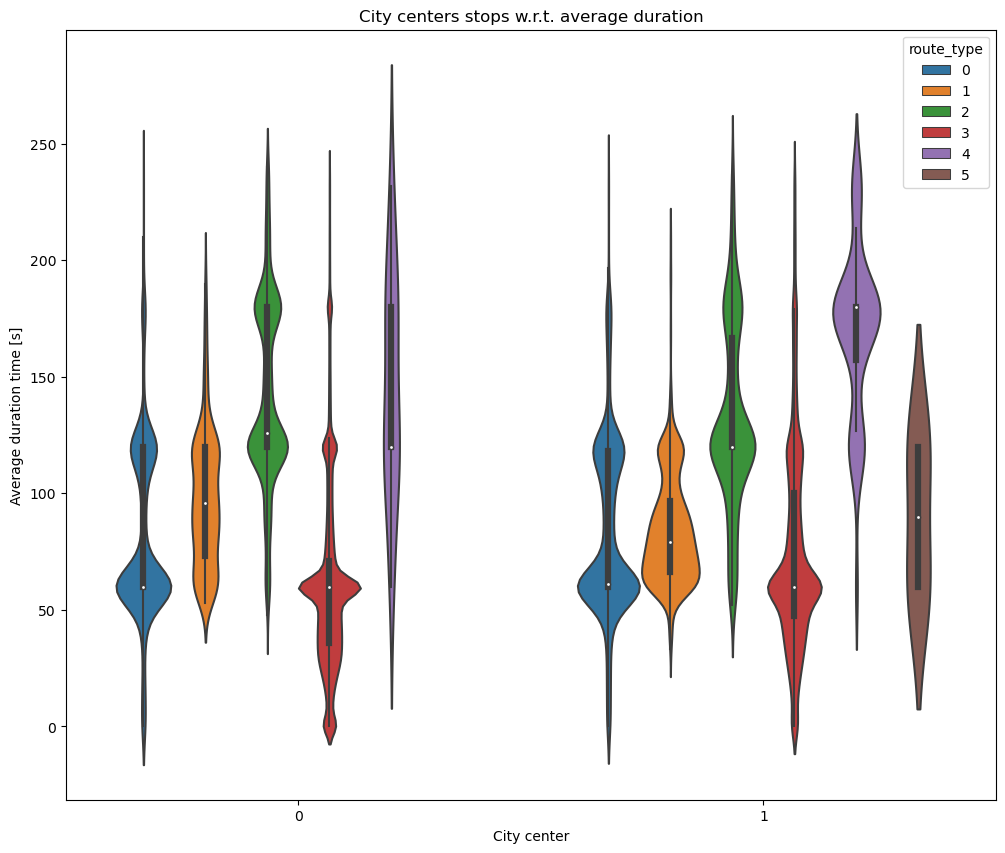

In [41]:
df_l_outliers = df_l[df_l['duration_avg'] < df_l['duration_avg'].quantile(0.97)]
sns.violinplot(df_l_outliers, x='city_center_from', y='duration_avg', hue='route_type')
plt.title(f'City centers stops w.r.t. average duration')
plt.ylabel('Average duration time [s]')
plt.xlabel('City center')
plt.show()

## Number of vehicles

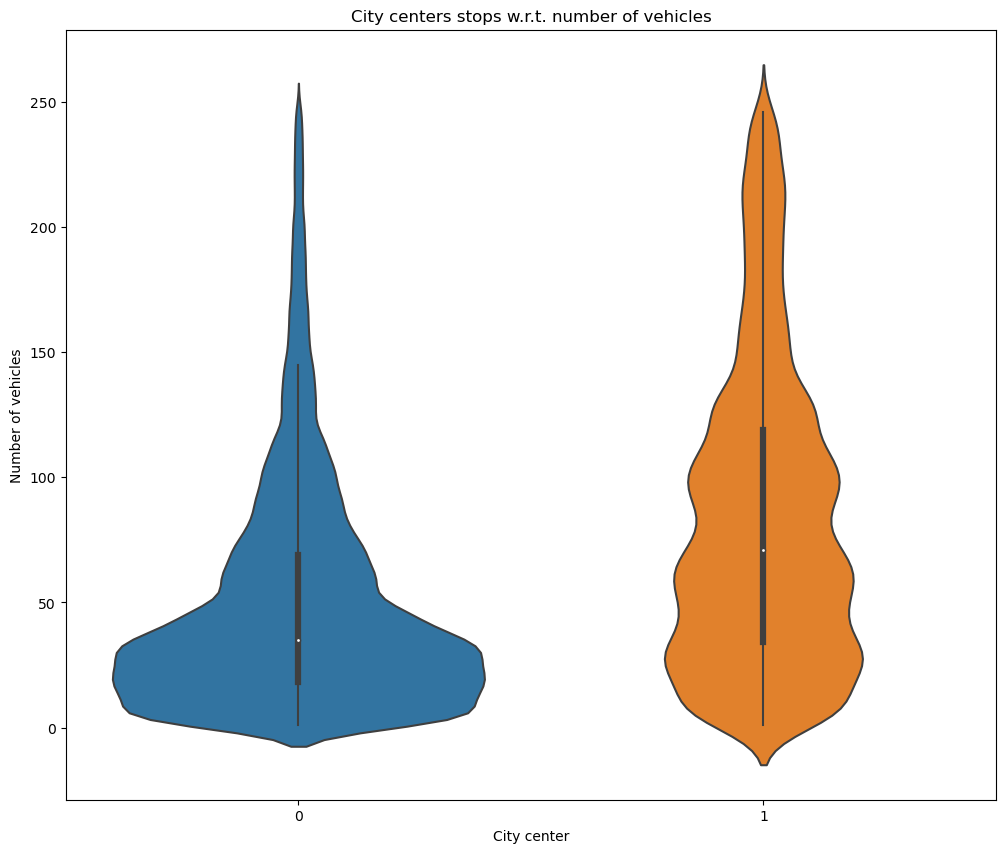

In [42]:
df_l_outliers = df_l[df_l['n_vehicles'] < df_l['n_vehicles'].quantile(0.97)]
sns.violinplot(df_l_outliers, x='city_center_from', y='n_vehicles')
plt.title(f'City centers stops w.r.t. number of vehicles')
plt.ylabel('Number of vehicles')
plt.xlabel('City center')
plt.show()

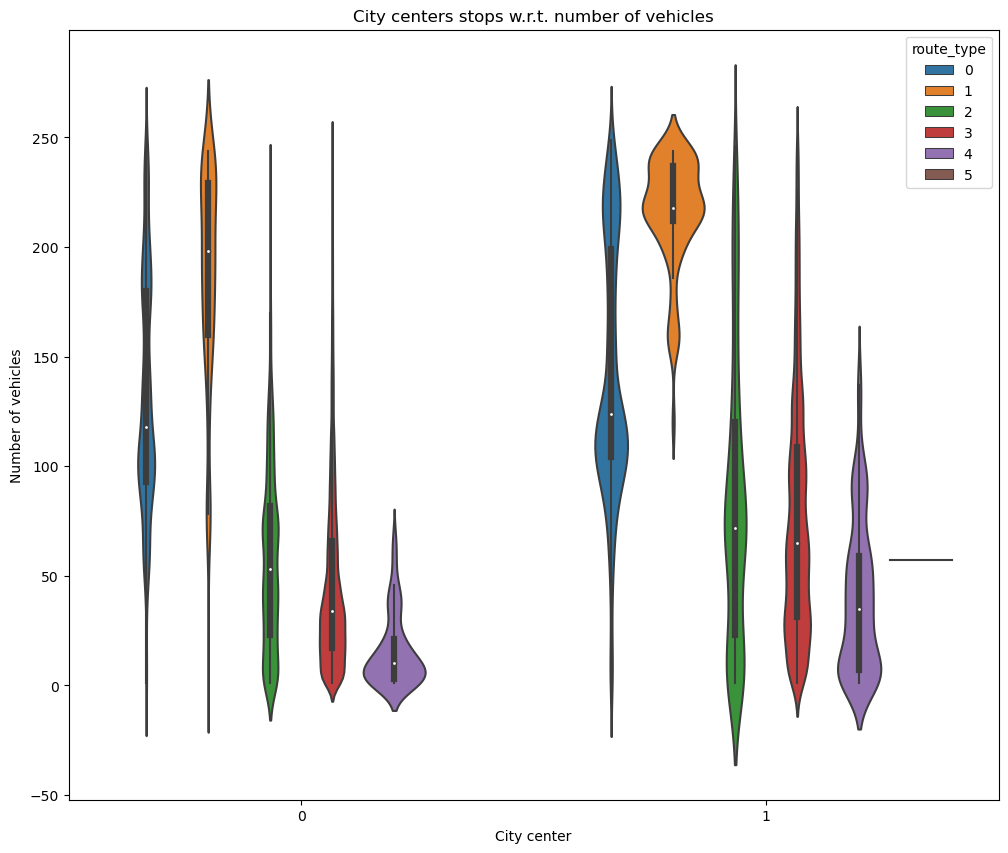

In [43]:
df_l_outliers = df_l[df_l['n_vehicles'] < df_l['n_vehicles'].quantile(0.97)]
sns.violinplot(df_l_outliers, x='city_center_from', y='n_vehicles', hue='route_type')
plt.title(f'City centers stops w.r.t. number of vehicles')
plt.ylabel('Number of vehicles')
plt.xlabel('City center')
plt.show()

## Distances to other stops

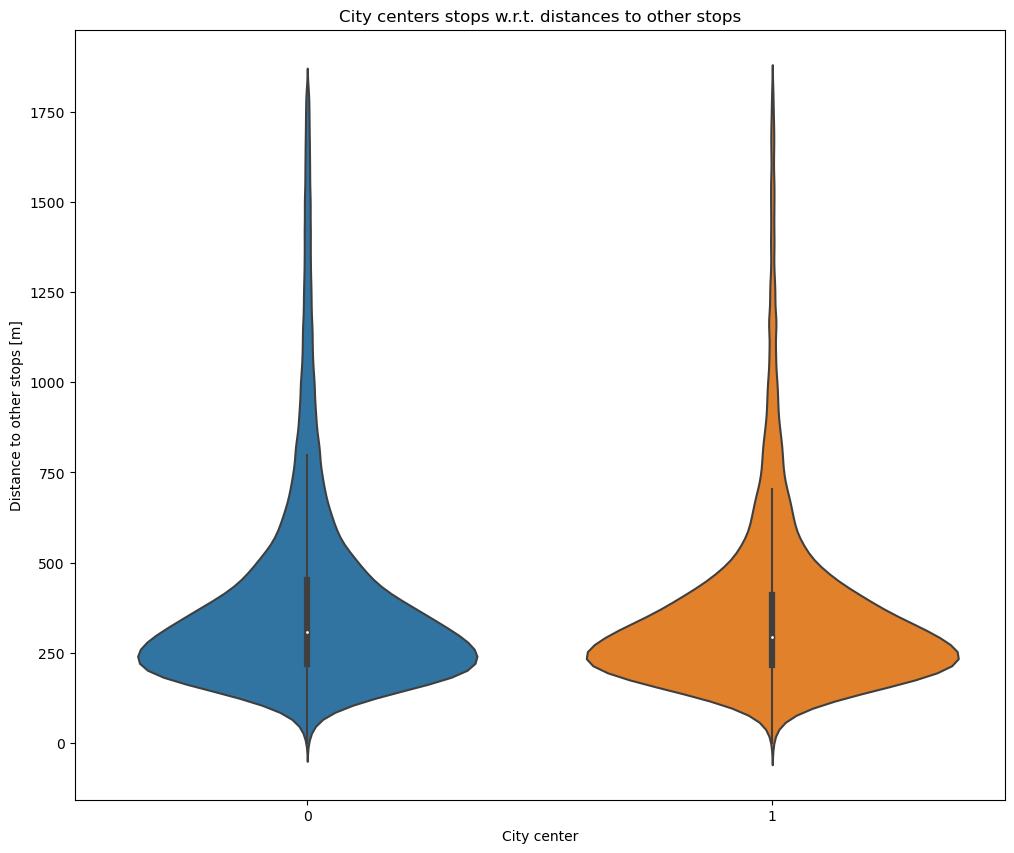

In [44]:
df_l_outliers = df_l[df_l['d'] < df_l['d'].quantile(0.97)]
sns.violinplot(df_l_outliers, x='city_center_from', y='d')
plt.title(f'City centers stops w.r.t. distances to other stops')
plt.ylabel('Distance to other stops [m]')
plt.xlabel('City center')
plt.show()

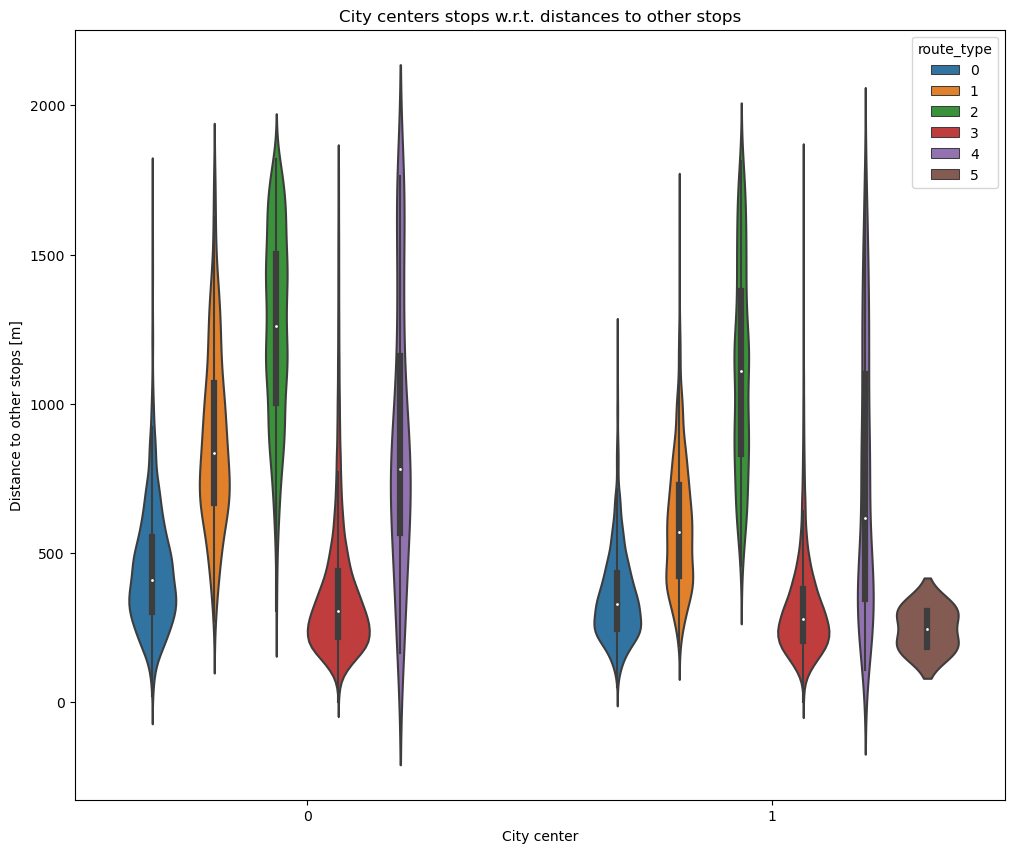

In [45]:
df_l_outliers = df_l[df_l['d'] < df_l['d'].quantile(0.97)]
sns.violinplot(df_l_outliers, x='city_center_from', y='d', hue='route_type')
plt.title(f'City centers stops w.r.t. distances to other stops')
plt.ylabel('Distance to other stops [m]')
plt.xlabel('City center')
plt.show()